In [2]:
# packages for dealing with Sidra API
import requests
import json

# packages for treating the data
import pandas as pd
import numpy as np
import unidecode

# packages for dealing with geographical data
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import osmnx as ox
from osmnx.distance import get_nearest_node

### Building the dataset

This project aims to measure the pedestrian acessibility in Natal, Brazil. With that in mind, we use data from [Sidra API](http://api.sidra.ibge.gov.br/) regarding the neighborhoods, average income and population size. Further, we calculate the smallest distance from a central point of the neighborhood to an amenity. All this informations togheter will become our dataset.

In [3]:
# Recover income by neighborhood in Natal (2010)
# from Sidra's Table 3170 (http://api.sidra.ibge.gov.br/desctabapi.aspx?c=3170)
headers = {
    'Content-Type': 'application/json;charset=UTF-8',
    'User-Agent': 'google-colab',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
}

endnode = "http://api.sidra.ibge.gov.br/values/t/3170/p/2010/v/842/N102/in%20n6%202408102"
response = requests.get(endnode,headers=headers)
raw_data_income = response.json()

In [4]:
# Recover the number of inhabitants
endnode_people = "http://api.sidra.ibge.gov.br/values/t/3170/p/2010/v/841/N102/in%20n6%202408102"
response = requests.get(endnode_people,headers=headers)
raw_data_people = response.json()

The variables 842 and 841 give us, respectivelly, the information about income and population of each neighborhood. Now we take a look at the responses to find out the meaning of each key-value pair.

In [5]:
raw_data_income[0]

{'NC': 'Nível Territorial (Código)',
 'NN': 'Nível Territorial',
 'MC': 'Unidade de Medida (Código)',
 'MN': 'Unidade de Medida',
 'V': 'Valor',
 'D1C': 'Ano (Código)',
 'D1N': 'Ano',
 'D2C': 'Variável (Código)',
 'D2N': 'Variável',
 'D3C': 'Bairro (Código)',
 'D3N': 'Bairro',
 'D4C': 'Situação do domicílio (Código)',
 'D4N': 'Situação do domicílio',
 'D5C': 'Sexo (Código)',
 'D5N': 'Sexo',
 'D6C': 'Grupo de idade (Código)',
 'D6N': 'Grupo de idade'}

In [6]:
raw_data_people[0]

{'NC': 'Nível Territorial (Código)',
 'NN': 'Nível Territorial',
 'MC': 'Unidade de Medida (Código)',
 'MN': 'Unidade de Medida',
 'V': 'Valor',
 'D1C': 'Ano (Código)',
 'D1N': 'Ano',
 'D2C': 'Variável (Código)',
 'D2N': 'Variável',
 'D3C': 'Bairro (Código)',
 'D3N': 'Bairro',
 'D4C': 'Situação do domicílio (Código)',
 'D4N': 'Situação do domicílio',
 'D5C': 'Sexo (Código)',
 'D5N': 'Sexo',
 'D6C': 'Grupo de idade (Código)',
 'D6N': 'Grupo de idade'}

The keys for neighborhood code, neighborhood name, and value for each variable (income and population), are, in this order, `D3C`, `D3N` and `V`. We use these to build the first dataframes. Only the dataset for income will have the name, because the two datasets will be merged using the neighboorhood code.

In [7]:
# create a dataset for each json
income_df = pd.DataFrame(raw_data_income, columns=['D3C', 'D3N', 'V'])
income_df.drop(labels=0, inplace=True)

people_df = pd.DataFrame(raw_data_people, columns=['D3C', 'V'])
people_df.drop(labels=0, inplace=True)

In [8]:
# quick checkout on the results
print(income_df.head())
print(people_df.head())

          D3C                         D3N        V
1  2408102001    Santos Reis - Natal - RN   984.31
2  2408102002  Praia do Meio - Natal - RN  1658.16
3  2408102003          Rocas - Natal - RN   969.39
4  2408102004        Ribeira - Natal - RN  2825.82
5  2408102005     Petrópolis - Natal - RN  4736.63
          D3C     V
1  2408102001  2989
2  2408102002  2810
3  2408102003  5806
4  2408102004  1453
5  2408102005  3288


In [9]:
neighborhood_df = income_df.merge(people_df, on='D3C')
neighborhood_df.head()

,D3C,D3N,V_x,V_y
0,2408102001,Santos Reis - Natal - RN,984.31,2989
1,2408102002,Praia do Meio - Natal - RN,1658.16,2810
2,2408102003,Rocas - Natal - RN,969.39,5806
3,2408102004,Ribeira - Natal - RN,2825.82,1453
4,2408102005,Petrópolis - Natal - RN,4736.63,3288


Finally, the columns will be renamed. There is a need to remove any accents from the names of the neighborhoods. This is necessary to enable the merge with the geojson data, that only has names, not codes for identifying the regions. Also, the redundant "- Natal - RN" must be removed too.

In [10]:
new_columns = {'V_x':'income', 'D3C':'id', 'D3N':'name', 'V_y':'inhabitants'}
neighborhood_df.rename(columns=new_columns, inplace=True)

# normalize the names
neighborhood_df['name'] = neighborhood_df.name.str.split(pat=' - ', n=1, expand=True)[0]
neighborhood_df['name_norm'] = neighborhood_df.name.apply(lambda x:unidecode.unidecode(x))

In [11]:
neighborhood_df.head()

,id,name,income,inhabitants,name_norm
0,2408102001,Santos Reis,984.31,2989,Santos Reis
1,2408102002,Praia do Meio,1658.16,2810,Praia do Meio
2,2408102003,Rocas,969.39,5806,Rocas
3,2408102004,Ribeira,2825.82,1453,Ribeira
4,2408102005,Petrópolis,4736.63,3288,Petropolis


Last but not least, we will add the administrative regions or zones, as they are known, to which the districts belong to the Ordinary Law nº 03878/89 of the municipality of Natal. This information was previously inserted into a JSON file

In [14]:
with open('../data/interim/zones.json') as fp:
    zones = json.load(fp)
neighborhood_df['zone'] = neighborhood_df['name'].map(zones) 

In [15]:
neighborhood_df.head()

,id,name,income,inhabitants,name_norm,zone
0,2408102001,Santos Reis,984.31,2989,Santos Reis,East
1,2408102002,Praia do Meio,1658.16,2810,Praia do Meio,East
2,2408102003,Rocas,969.39,5806,Rocas,East
3,2408102004,Ribeira,2825.82,1453,Ribeira,East
4,2408102005,Petrópolis,4736.63,3288,Petropolis,East


#### Retrieving the centroid of each neighborhood
The GeoJSON file provides a polygon that describes Natal geographically. If we get its central point, which means its centroid, we can measure the distance between the center of the area and a point of interest as school, bank, police station, etc. [geopandas](http://geopandas.org/) module is responsible for dealing with this data.

In [16]:
# load the GeoJSON data and use 'UTF-8'encoding
geojson_natal_file = requests.get('https://github.com/nymarya/data-science-one/blob/master/Lesson%2314/natal.geojson?raw=true')
geo_json_natal = geojson_natal_file.json()

In [17]:
# save it in a local file
with open('../data/external/natal.geojson', 'w') as file:  
    json.dump(geo_json_natal, file)
    
geojson_df = gpd.read_file("../data/external/natal.geojson")

Let's make sure that the data is all there

In [22]:
geojson_df.head()

,id,@id,admin_level,boundary,is_in,name,place,type,alt_name,wikidata,geometry
0,relation/388146,relation/388146,10,administrative,Natal,Pitimbu,suburb,boundary,None,None,"POLYGON ((-35.24373 -5.84203, -35.24379 -5.842..."
1,relation/388147,relation/388147,10,administrative,Natal,Planalto,suburb,boundary,None,None,"POLYGON ((-35.25382 -5.86629, -35.25361 -5.866..."
2,relation/397022,relation/397022,10,administrative,Natal,Ponta Negra,suburb,boundary,None,None,"POLYGON ((-35.18902 -5.89079, -35.18895 -5.890..."
3,relation/1230018,relation/1230018,10,administrative,Natal,Neópolis,suburb,boundary,None,None,"POLYGON ((-35.20031 -5.87341, -35.19996 -5.873..."
4,relation/1230020,relation/1230020,10,administrative,Natal,Capim Macio,suburb,boundary,None,None,"POLYGON ((-35.18946 -5.87242, -35.18907 -5.871..."


In [29]:
geojson_df.name.unique()

array(['Pitimbu', 'Planalto', 'Ponta Negra', 'Neópolis', 'Capim Macio',
       'Lagoa Azul', 'Pajuçara', 'Lagoa Seca', 'Barro Vermelho',
       'Candelária', 'Praia do Meio', 'Rocas', 'Santos Reis', 'Redinha',
       'Salinas', 'Igapó', 'Nossa Senhora da Apresentação', 'Potengi',
       'Ribeira', 'Cidade Alta', 'Alecrim', 'Nordeste', 'Quintas',
       'Bom Pastor', 'Dix-Sept Rosado', 'Nossa Senhora de Nazaré',
       'Lagoa Nova', 'Mãe Luiza', 'Nova Descoberta', 'Tirol',
       'Petrópolis', 'Areia Preta', 'Cidade Nova', 'Cidade da Esperança',
       'Felipe Camarão', 'Guarapes'], dtype=object)

In [30]:
n_neighborhoods1 = len(neighborhood_df.name.unique())
n_neighborhoods2 = len(geojson_df.name.unique())
assert n_neighborhoods1 == n_neighborhoods2

Knowing that the polygon is a complex structure/data type, merging the datasets using pandas is also complex. So in this step, we simply find the neighborhood by name and insert the new data in a less pythonist way.

In [32]:
# fix typo
typo_df = geojson_df.query('name == "Felipe Camarão"')
geojson_df.loc[typo_df.index.values, 'name'] = 'Filipe Camarão'

# save each coordinate
geojson_df['name_norm'] = geojson_df.name.apply(lambda x:unidecode.unidecode(x))
neighborhood_df = neighborhood_df.merge(geojson_df[['name_norm', 'geometry']], on='name_norm')


neighborhood_df.head()

/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/home/mayra/workspace/fear-the-walking-distance/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


,id,name,income,inhabitants,name_norm,zone,x,y,geometry
0,2408102001,Santos Reis,984.31,2989,Santos Reis,East,NaN,NaN,"POLYGON ((-35.20819 -5.76785, -35.20420 -5.768..."
1,2408102002,Praia do Meio,1658.16,2810,Praia do Meio,East,NaN,NaN,"POLYGON ((-35.19504 -5.77323, -35.19513 -5.773..."
2,2408102003,Rocas,969.39,5806,Rocas,East,NaN,NaN,"POLYGON ((-35.19664 -5.77523, -35.19653 -5.774..."
3,2408102004,Ribeira,2825.82,1453,Ribeira,East,NaN,NaN,"POLYGON ((-35.20412 -5.76860, -35.20420 -5.768..."
4,2408102005,Petrópolis,4736.63,3288,Petropolis,East,NaN,NaN,"POLYGON ((-35.19536 -5.78434, -35.19532 -5.784..."


In [33]:
# create columns in the main df for the centroid
neighborhood_df['x'] = neighborhood_df.geometry.apply(lambda x: Polygon(x).centroid.x)
neighborhood_df['y'] = neighborhood_df.geometry.apply(lambda x: Polygon(x).centroid.y)

neighborhood_df.head()

,id,name,income,inhabitants,name_norm,zone,x,y,geometry
0,2408102001,Santos Reis,984.31,2989,Santos Reis,East,-35.199888,-5.762731,"POLYGON ((-35.20819 -5.76785, -35.20420 -5.768..."
1,2408102002,Praia do Meio,1658.16,2810,Praia do Meio,East,-35.195083,-5.778860,"POLYGON ((-35.19504 -5.77323, -35.19513 -5.773..."
2,2408102003,Rocas,969.39,5806,Rocas,East,-35.200216,-5.774142,"POLYGON ((-35.19664 -5.77523, -35.19653 -5.774..."
3,2408102004,Ribeira,2825.82,1453,Ribeira,East,-35.205768,-5.776236,"POLYGON ((-35.20412 -5.76860, -35.20420 -5.768..."
4,2408102005,Petrópolis,4736.63,3288,Petropolis,East,-35.198393,-5.784591,"POLYGON ((-35.19536 -5.78434, -35.19532 -5.784..."


#### Calculating the distance
Next up, we obtain the graph corresponding to Natal using the library [OSMnx](https://osmnx.readthedocs.io/en/stable/osmnx.html). Using graph theory, it is possible to calculate what we need by measuring the distance between a node (centroid) and the other nodes (amenities) and finding the smallest of them.

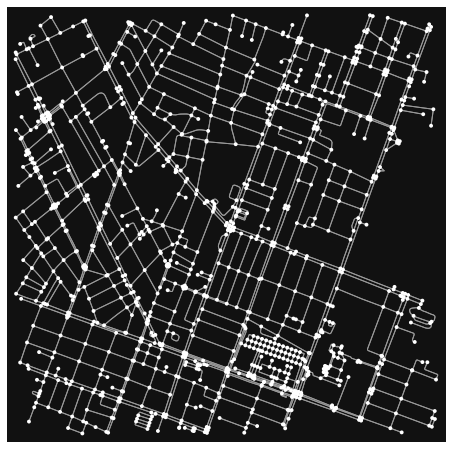

In [36]:
city_address = 'Natal, Rio Grande do Norte'
G = ox.graph_from_address(city_address, network_type='walk')
G = ox.project_graph(G)
cityGraph, axes = ox.plot_graph(G)

The last thing missing for the problem is the location of the amenities. There are many registered in OpenStreetMap, so we retrive using `OSMnx`. The points of interest were chosen thinking of basic needs: healthcare, education, food, money and security. 

In [40]:
amenities = {'hospital': True, 'clinic': True, 'restaurant': True, 'bank': True,
             'cafe': True, 'school': True, 'police': True, 'pharmacy': True, }

all_pois = ox.geometries.geometries_from_address(city_address, dist=50000, tags=amenities)